# 基底関数と正則化

In [23]:
#import 
import pandas as pd
import seaborn as sns
from pyearth import Earth
import scipy
import scipy.linalg
from scipy.interpolate import UnivariateSpline

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf

import patsy as patsy

plt.rcParams['font.family'] = 'Noto Sans CJK JP' #全体のフォントを設定

## 5.2 区分的多項式とスプライン

In [2]:
# Limits
x0, xi0, xi1, x1 = -1, 1.5, 4.5, 7
y0, y1 = 0, 4

# Sine line
xgrid = scipy.linspace(x0, x1, 100)
ygrid = scipy.cos(xgrid)+2

# Random sample
size_sample = 60
err_sample = scipy.randn(size_sample)*.3
x_sample = scipy.linspace(x0, x1, size_sample)
y_sample = scipy.cos(x_sample)+2+err_sample

Text(0.5,1,'3次自然スプライン')

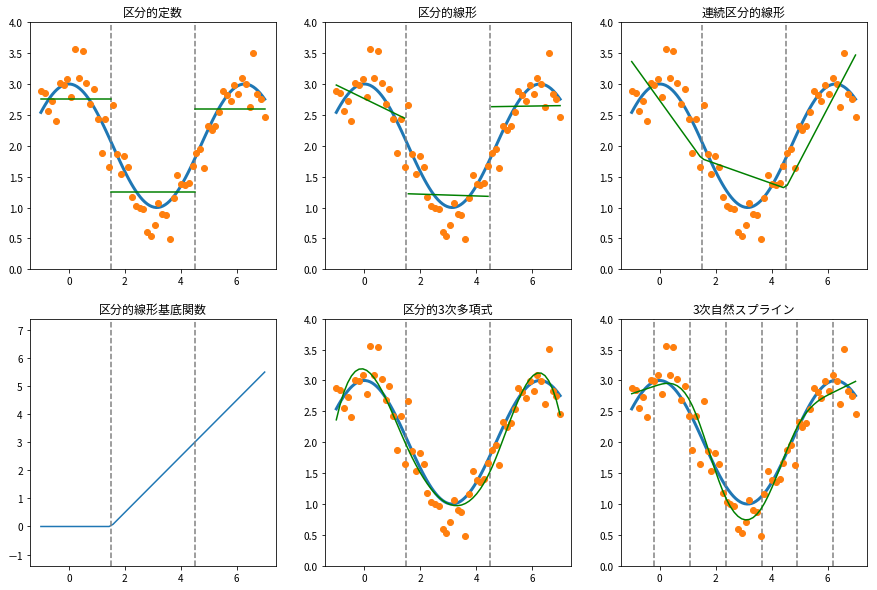

In [3]:
fig51 = plt.figure(51, figsize=(15, 10))
ax1 = fig51.add_subplot(2, 3, 1)
ax1.plot(xgrid, ygrid, linewidth=3)
ax1.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax1.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax1.set_ylim(y0, y1)
ax1.plot(x_sample, y_sample, 'o')

# Split
mask_split1 = x_sample < xi0
mask_split2 = scipy.all([x_sample >= xi0, x_sample < xi1], axis=0)
mask_split3 = xi1 <= x_sample
x_split1 = x_sample[mask_split1]
x_split2 = x_sample[mask_split2]
x_split3 = x_sample[mask_split3]
y_split1 = y_sample[mask_split1]
y_split2 = y_sample[mask_split2]
y_split3 = y_sample[mask_split3]

# 区分的定数
y_split1_mean = y_split1.mean()
y_split2_mean = y_split2.mean()
y_split3_mean = y_split3.mean()
ax1.plot([x0, xi0], [y_split1_mean, y_split1_mean], color='g')
ax1.plot([xi0, xi1], [y_split2_mean, y_split2_mean], color='g')
ax1.plot([xi1, x1], [y_split3_mean, y_split3_mean], color='g')
ax1.set_title(u'区分的定数')

# 区分的線形
y_split1_centered = y_split1-y_split1_mean
y_split2_centered = y_split2-y_split2_mean
y_split3_centered = y_split3-y_split3_mean

beta_split1 = y_split1_centered.dot(x_split1)/(x_split1*x_split1).sum()
beta_split2 = y_split2_centered.dot(x_split2)/(x_split2*x_split2).sum()
beta_split3 = y_split3_centered.dot(x_split3)/(x_split3*x_split3).sum()

y_split1_hat = beta_split1*x_split1+y_split1_mean
y_split2_hat = beta_split2*x_split2+y_split2_mean
y_split3_hat = beta_split3*x_split3+y_split3_mean

ax2 = fig51.add_subplot(2, 3, 2)
ax2.plot(xgrid, ygrid, linewidth=3)
ax2.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax2.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax2.set_ylim(y0, y1)
ax2.plot(x_sample, y_sample, 'o')

ax2.plot(x_split1, y_split1_hat, color='g')
ax2.plot(x_split2, y_split2_hat, color='g')
ax2.plot(x_split3, y_split3_hat, color='g')
ax2.set_title(u'区分的線形')

# 連続区分的線形
h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = scipy.where(x_sample < xi0, 0, x_sample-xi0)
h4 = scipy.where(x_sample < xi1, 0, x_sample-xi1)
H = scipy.vstack((h1, h2, h3, h4)).T

## 最小二乗法
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat = H @ beta

ax3 = fig51.add_subplot(2, 3, 3)
ax3.plot(xgrid, ygrid, linewidth=3)
ax3.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax3.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax3.set_ylim(y0, y1)
ax3.plot(x_sample, y_sample, 'o')
ax3.plot(x_sample, y_hat, color='g')
ax3.set_title(u'連続区分的線形')

ax4 = fig51.add_subplot(2, 3, 4)
ax4.plot(x_sample, h3)
ax4.plot([xi0, xi0], ax4.get_xlim(), '--', color='gray')
ax4.plot([xi1, xi1], ax4.get_xlim(), '--', color='gray')
ax4.set_ylim(ax4.get_xlim())
ax4.set_title(u'区分的線形基底関数')

# 3次スプライン
h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = scipy.copy(x_sample*x_sample)
h4 = scipy.copy(x_sample*x_sample*x_sample)
h5 = scipy.where(x_sample < xi0, 0, (x_sample-xi0)**3)
h6 = scipy.where(x_sample < xi1, 0, (x_sample-xi1)**3)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

## 最小二乗法
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat_2 = H @ beta

ax5 = fig51.add_subplot(2, 3, 5)
ax5.plot(xgrid, ygrid, linewidth=3)
ax5.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax5.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax5.set_ylim(y0, y1)
ax5.plot(x_sample, y_sample, 'o')
ax5.plot(x_sample, y_hat_2, color='g')
ax5.set_title(u'区分的3次多項式')

# 3次自然スプライン
xis = scipy.array([.1, .26, .42, .58, .74, .9])*8-1
def d(x:scipy.ndarray, xis:scipy.ndarray, k:int)->scipy.ndarray:
    return (scipy.where(x < xis[k], 0, (x-xis[k])**3)
            - scipy.where(x < xis[-1], 0, (x-xis[-1])**3))/(xis[-1]-xis[k])

h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = d(x_sample, xis, 0)-d(x_sample, xis, -2)
h4 = d(x_sample, xis, 1)-d(x_sample, xis, -2)
h5 = d(x_sample, xis, 2)-d(x_sample, xis, -2)
h6 = d(x_sample, xis, 3)-d(x_sample, xis, -2)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat_3 = H @ beta

ax6 = fig51.add_subplot(2, 3, 6)
ax6.plot(xgrid, ygrid, linewidth=3)
for xi in xis:
    ax6.plot([xi, xi], [y0, y1], '--', color='gray')
ax6.set_ylim(y0, y1)
ax6.plot(x_sample, y_sample, 'o')
ax6.plot(x_sample, y_hat_3, color='g')
ax6.set_title(u'3次自然スプライン')

### 南アフリカの心臓疾患データ
chapter4でロジスティック回帰を行なった結果，以下の通りになった．
```
        Term     Coefficient
--------------------------------
      intercept       -4.129600
            sbp        0.005761
        tobacco        0.079526
            ldl        0.184779
        famhist        0.939185
        obesity       -0.034543
        alcohol        0.000607
            age        0.042541
```           
sbpが有意でないこと，obesityが負であるのは少し変．

spline + logistic を行って解析

参考
- https://rpubs.com/lance4869/SAheart

In [4]:
df_saheart = pd.read_csv('./data/heart/SAheart.data', index_col=0)
df_saheart['famhist'] = df_saheart['famhist'].map({'Present': 1,
                                                   'Absent': 0})
df_saheart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [5]:
# mod = smf.Logit(formula='chd ~ sbp + tobacco + ldl + adiposity + typea + obesity + alcohol + age', data=df_saheart)
y, X = patsy.dmatrices('chd ~ cr(sbp, df=4) + cr(tobacco, df=4) + cr(ldl, df=4) + C(famhist)' 
                       '+ cr(obesity, df=4) + cr(age, df=4)', df_saheart, return_type = 'dataframe')

In [6]:
X.head()

,Intercept,C(famhist)[T.1],"cr(sbp, df=4)[0]","cr(sbp, df=4)[1]","cr(sbp, df=4)[2]","cr(sbp, df=4)[3]","cr(tobacco, df=4)[0]","cr(tobacco, df=4)[1]","cr(tobacco, df=4)[2]","cr(tobacco, df=4)[3]",...,"cr(ldl, df=4)[2]","cr(ldl, df=4)[3]","cr(obesity, df=4)[0]","cr(obesity, df=4)[1]","cr(obesity, df=4)[2]","cr(obesity, df=4)[3]","cr(age, df=4)[0]","cr(age, df=4)[1]","cr(age, df=4)[2]","cr(age, df=4)[3]"
row.names,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,-0.004259,0.022786,0.985079,-0.003607,0.707020,-2.059885,2.247823,0.105043,...,1.094701,0.002900,-0.018495,0.693792,0.328514,-0.003811,0.019924,-0.128417,0.945817,0.162676
2,1.0,0.0,-0.096475,0.666457,0.456891,-0.026873,0.993521,0.006954,-0.000478,0.000004,...,0.305825,-0.003343,0.014434,-0.330201,1.300120,0.015648,0.003780,-0.024365,0.099653,0.920932
3,1.0,1.0,0.304391,0.797340,-0.110079,0.008348,0.948179,0.055607,-0.003818,0.000033,...,-0.097856,0.001250,0.017086,-0.390860,1.353417,0.020358,-0.017434,0.114318,0.949754,-0.046639
4,1.0,1.0,0.045105,-0.241227,1.118224,0.077898,0.292380,-0.851842,1.543510,0.015952,...,1.408960,0.021833,0.037402,-0.855604,1.720611,0.097592,0.019568,-0.126124,0.567320,0.539236
5,1.0,1.0,-0.063609,0.956623,0.115495,-0.008509,0.779548,-2.271196,2.339355,0.152292,...,-0.092483,0.001181,-0.017318,0.488508,0.533756,-0.004946,0.006893,-0.044430,1.005249,0.032288


In [7]:
logispline = sm.Logit(y, X)
results = logispline.fit()
print(results.summary())

         Current function value: 0.506720
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      445
Method:                           MLE   Df Model:                           16
Date:                Fri, 25 May 2018   Pseudo R-squ.:                  0.2146
Time:                        21:53:49   Log-Likelihood:                -234.10
converged:                      False   LL-Null:                       -298.05
                                        LLR p-value:                 1.640e-19
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2852        nan        nan        nan         nan         nan
C(famhist)[T.1]          0.9908    

/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encou

h1, h2, h3, h4を求めたので，各項に対する自然スプライン関数が描ける

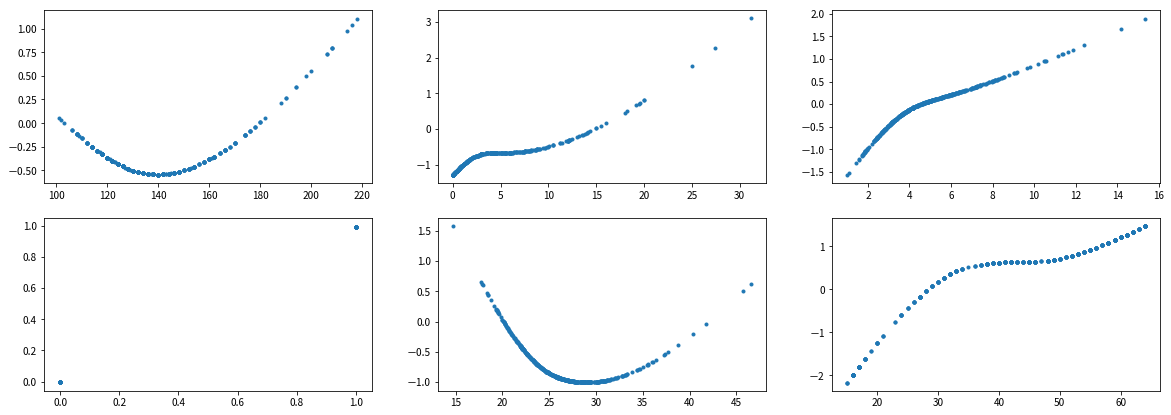

In [8]:
fig51 = plt.figure(51, figsize=(20, 7))

ax1 = fig51.add_subplot(2, 3, 1)
obe = patsy.dmatrix("cr(sbp, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [0.0522, -0.4950, -0.3729, 1.1008]
plt.scatter(df_saheart['sbp'], obe.as_matrix() @ theta, marker=".")

ax2 = fig51.add_subplot(2, 3, 2)
obe = patsy.dmatrix("cr(tobacco, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [-1.2931, -0.8552, -0.6680, 3.1015]
plt.scatter(df_saheart['tobacco'], obe.as_matrix() @ theta, marker=".")

ax3 = fig51.add_subplot(2, 3, 3)
obe = patsy.dmatrix("cr(ldl, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [-1.5733, -0.1830, 0.1451, 1.8964]
plt.scatter(df_saheart['ldl'], obe.as_matrix() @ theta, marker=".")

ax4 = fig51.add_subplot(2, 3, 4)
obe = patsy.dmatrix("C(famhist)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [0.9908]
plt.scatter(df_saheart['famhist'], obe.as_matrix() @ theta, marker=".")

ax5 = fig51.add_subplot(2, 3, 5)
obe = patsy.dmatrix("cr(obesity, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [1.5761, -0.7544, -0.9913, 0.6166]
plt.scatter(df_saheart['obesity'], obe.as_matrix() @ theta, marker=".")

ax6 = fig51.add_subplot(2, 3, 6)
obe = patsy.dmatrix("cr(age, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [-2.1737, 0.3453, 0.6637, 1.4701]
plt.scatter(df_saheart['age'], obe.as_matrix() @ theta, marker=".")

v2

In [9]:
logreg2 = LogisticRegression()
logreg2.fit(X, y)

print('{0:>15} {1:>15}'.format('Term', 'Coefficient'))
print('-'*32)
table_term = list(X.columns)
for term, coeff in zip(table_term, logreg2.coef_[0]):
    print('{0:>15} {1:>15f}'.format(term, coeff))

           Term     Coefficient
--------------------------------
      Intercept       -0.125261
C(famhist)[T.1]        0.880397
cr(sbp, df=4)[0]        0.034274
cr(sbp, df=4)[1]       -0.503433
cr(sbp, df=4)[2]       -0.313272
cr(sbp, df=4)[3]        0.657170
cr(tobacco, df=4)[0]       -0.702331
cr(tobacco, df=4)[1]       -0.330524
cr(tobacco, df=4)[2]        0.008189
cr(tobacco, df=4)[3]        0.899404
cr(ldl, df=4)[0]       -0.860288
cr(ldl, df=4)[1]       -0.166922
cr(ldl, df=4)[2]        0.223423
cr(ldl, df=4)[3]        0.678527
cr(obesity, df=4)[0]        0.663876
cr(obesity, df=4)[1]       -0.434863
cr(obesity, df=4)[2]       -0.621460
cr(obesity, df=4)[3]        0.267186
cr(age, df=4)[0]       -1.462484
cr(age, df=4)[1]       -0.039418
cr(age, df=4)[2]        0.353337
cr(age, df=4)[3]        1.023305


/Users/tela/.anyenv/envs/pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


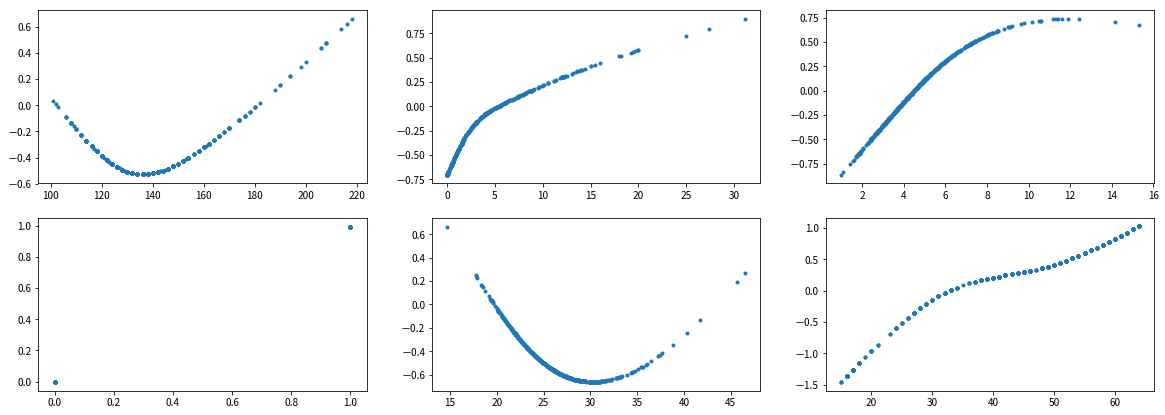

In [10]:
fig51 = plt.figure(51, figsize=(20, 7))

ax1 = fig51.add_subplot(2, 3, 1)
obe = patsy.dmatrix("cr(sbp, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [0.034274,-0.503433,-0.313272,0.657170]
plt.scatter(df_saheart['sbp'], obe.as_matrix() @ theta, marker=".")

ax2 = fig51.add_subplot(2, 3, 2)
obe = patsy.dmatrix("cr(tobacco, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [-0.702331,-0.330524,0.008189,0.899404]
plt.scatter(df_saheart['tobacco'], obe.as_matrix() @ theta, marker=".")

ax3 = fig51.add_subplot(2, 3, 3)
obe = patsy.dmatrix("cr(ldl, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [-0.860288,-0.166922,0.223423,0.678527]
plt.scatter(df_saheart['ldl'], obe.as_matrix() @ theta, marker=".")

ax4 = fig51.add_subplot(2, 3, 4)
obe = patsy.dmatrix("C(famhist)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [0.9908]
plt.scatter(df_saheart['famhist'], obe.as_matrix() @ theta, marker=".")

ax5 = fig51.add_subplot(2, 3, 5)
obe = patsy.dmatrix("cr(obesity, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [0.663876,-0.434863,-0.621460,0.267186]
plt.scatter(df_saheart['obesity'], obe.as_matrix() @ theta, marker=".")

ax6 = fig51.add_subplot(2, 3, 6)
obe = patsy.dmatrix("cr(age, df=4)", df_saheart, return_type = 'dataframe')
obe = obe.drop(columns=['Intercept'])
theta = [-1.462484,-0.039418,0.353337,1.023305]
plt.scatter(df_saheart['age'], obe.as_matrix() @ theta, marker=".")

### 音素認識

In [11]:
df_phoneme = pd.read_csv('./data/phoneme/phoneme.data', index_col=0)
print(df_phoneme.shape)
df_phoneme.head()

(4509, 258)


,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,x.10,...,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
row.names,,,,,,,,,,,,,,,,,,,,,
1,9.85770,9.20711,9.81689,9.01692,9.05675,8.92518,11.28308,11.52980,10.79713,9.04747,...,12.68076,11.20767,13.69394,13.72055,12.16628,12.92489,12.51195,9.75527,sh,train.dr1.mcpm0.sa1
2,13.23079,14.19189,15.34428,18.11737,19.53875,18.32726,17.34169,17.16861,19.63557,20.15212,...,8.45714,8.77266,9.59717,8.45336,7.57730,5.38504,9.43063,8.59328,iy,train.dr1.mcpm0.sa1
3,10.81889,9.07615,9.77940,12.20135,12.59005,10.53364,8.54693,9.46049,11.96755,12.05282,...,5.00824,5.51019,5.95725,7.04992,7.02469,6.58416,6.27058,3.85042,dcl,train.dr1.mcpm0.sa1
4,10.53679,9.12147,10.84621,13.92331,13.52476,10.27831,8.97459,11.57109,12.35839,10.47826,...,5.85688,5.40324,6.07126,5.30651,4.27412,3.63384,3.22823,4.63123,dcl,train.dr1.mcpm0.sa1
5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,17.40394,...,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,aa,train.dr1.mcpm0.sa1


In [12]:
aa_fig = df_phoneme[df_phoneme['g']=='aa'][:10].drop(columns=['g','speaker'])
ao_fig = df_phoneme[df_phoneme['g']=='ao'][:10].drop(columns=['g','speaker'])

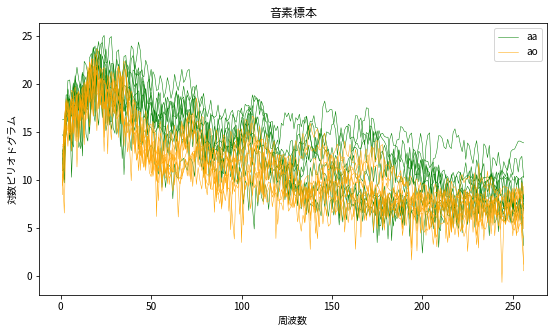

In [13]:
fig55 = plt.figure(55, figsize=(20, 5))
ax = fig55.add_subplot(1, 2, 1)
grid_x = range(1, 257)
plt_aa = ax.plot(grid_x, aa_fig.as_matrix().T,
                 color='green', linewidth=.5, label='aa')
plt_ao = ax.plot(grid_x, ao_fig.as_matrix().T,
                 color='orange', linewidth=.5, label='ao')
ax.legend((plt_aa[0], plt_ao[0]), ('aa', 'ao'))
ax.set_xlabel('周波数')
ax.set_ylabel('対数ピリオドグラム')
ax.set_title('音素標本')
plt.show()

ロジスティック回帰

In [14]:
aa_df = df_phoneme[df_phoneme['g']=='aa']
ao_df = df_phoneme[df_phoneme['g']=='ao']

In [15]:
# アンダーサンプリング
ao_df = ao_df.sample(n=695)
print(aa_df.shape, ao_df.shape)

(695, 258) (695, 258)


In [16]:
dataset = pd.concat([aa_df, ao_df])
X = dataset.drop(columns=['speaker', 'g'])
Y = dataset['g']
Y = Y.map({'aa': 1, 'ao': 0})

In [17]:
mat_X = X.as_matrix()
size_training, size_predictor = mat_X.shape
size_beta = size_predictor + 1

vec_y = Y.as_matrix()
mat_1X = scipy.hstack((scipy.ones((size_training, 1)), mat_X))

def fvec_p(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    num = scipy.exp(mat_x@vec_beta)
    return num/(num+1)

def fdiag_W(mat_x:scipy.ndarray, vec_beta:scipy.ndarray)->scipy.ndarray:
    vec_p = fvec_p(mat_x, vec_beta)
    return vec_p*(1-vec_p)

In [18]:
vec_beta_old = scipy.zeros(size_beta)
vec_increment = scipy.ones(size_beta)
while (vec_increment**2).sum() > 1e-8:
    vec_p = fvec_p(mat_1X, vec_beta_old)
    gradient = mat_1X.T @ (vec_y-vec_p)
    hessian = mat_1X.T @ scipy.diag(fdiag_W(mat_1X, vec_beta_old)) @ mat_1X
    vec_increment = scipy.linalg.solve(hessian, gradient)
    vec_beta_new = vec_beta_old + vec_increment
    vec_beta_old = vec_beta_new.copy()

スプライン

In [19]:
vec_beta_sp = np.delete(vec_beta_new, 0)

grid_x = range(0, 256)
x_sample = scipy.linspace(0, 256, 256)

# 3次自然スプライン
xis = scipy.array([.1, .26, .42, .58, .74, .9])*256-1
def d(x:scipy.ndarray, xis:scipy.ndarray, k:int)->scipy.ndarray:
    return (scipy.where(x < xis[k], 0, (x-xis[k])**3)
            - scipy.where(x < xis[-1], 0, (x-xis[-1])**3))/(xis[-1]-xis[k])

h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = d(x_sample, xis, 0)-d(x_sample, xis, -2)
h4 = d(x_sample, xis, 1)-d(x_sample, xis, -2)
h5 = d(x_sample, xis, 2)-d(x_sample, xis, -2)
h6 = d(x_sample, xis, 3)-d(x_sample, xis, -2)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T

HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ vec_beta_sp)
y_hat_4 = H @ beta

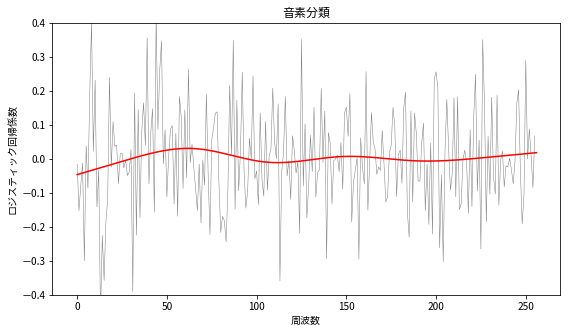

In [20]:
fig55 = plt.figure(55, figsize=(20, 5))
ax = fig55.add_subplot(1, 2, 1)
ax.plot(xgrid, ygrid, linewidth=3)
ax.set_ylim(-0.4, 0.4)
ax.plot(grid_x, vec_beta_sp,
                 color='gray', linewidth=.5)
ax.plot(x_sample, y_hat_4, color='r')
ax.set_xlabel('周波数')
ax.set_ylabel('ロジスティック回帰係数')
ax.set_title(u'音素分類')
plt.show()

## 5.4 平滑化スプライン

In [21]:
df_spmbnd = pd.read_table('./data/spnbmd/spnbmd.data', index_col=0)
df_spmbnd = df_spmbnd.sort_values(by='age')
df_mal = df_spmbnd[df_spmbnd['gender']=='male'].groupby('age').mean().reset_index()
df_fem = df_spmbnd[df_spmbnd['gender']=='female'].groupby('age').mean().reset_index()

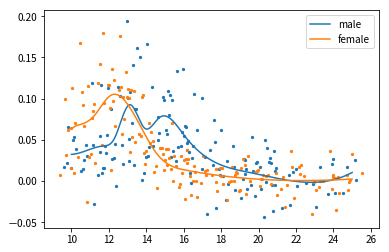

In [24]:
x_mal = df_mal['age'].values
y_mal = df_mal['spnbmd'].values

x_fem = df_fem['age'].values
y_fem = df_fem['spnbmd'].values

spl_mal = UnivariateSpline(x_mal, y_mal)
spl_mal.set_smoothing_factor(0.18)

spl_fem = UnivariateSpline(x_fem, y_fem)
spl_fem.set_smoothing_factor(0.12)

xs = np.linspace(10, 25, 10000)
plt.plot(xs, spl_mal(xs), 'C0', label="male")
plt.plot(xs, spl_fem(xs), 'C1', label="female")
plt.legend()

plt.scatter(x_mal, y_mal, c='C0', s=5)
plt.scatter(x_fem, y_fem, c='C1', s=5)